In [24]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [25]:
JKSE = yf.Ticker('^JKSE')
hist = JKSE.history(period="1y", auto_adjust=True)
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-18 00:00:00+07:00,6939.615234,6968.254883,6908.286133,6927.905762,187464900,0.0,0.0
2023-10-19 00:00:00+07:00,6927.632812,6927.980957,6840.365234,6846.426758,205941400,0.0,0.0
2023-10-20 00:00:00+07:00,6846.426758,6869.474121,6803.192871,6849.167969,194064800,0.0,0.0
2023-10-23 00:00:00+07:00,6849.167969,6853.449219,6730.875977,6741.963867,168543100,0.0,0.0
2023-10-24 00:00:00+07:00,6741.828125,6826.048828,6738.533203,6806.762207,141478700,0.0,0.0


In [26]:
hist_df = hist[["Close"]]
hist_df.head()

,Close
Date,
2023-10-18 00:00:00+07:00,6927.905762
2023-10-19 00:00:00+07:00,6846.426758
2023-10-20 00:00:00+07:00,6849.167969
2023-10-23 00:00:00+07:00,6741.963867
2023-10-24 00:00:00+07:00,6806.762207


In [34]:
hist_df.index = pd.to_datetime(hist_df.index)
hist_df.index = hist_df.index.date
hist_df.index = pd.to_datetime(hist_df.index)

In [35]:
hist_df

,Close
2023-10-18,6927.905762
2023-10-19,6846.426758
2023-10-20,6849.167969
2023-10-23,6741.963867
2023-10-24,6806.762207
...,...
2024-10-14,7559.654785
2024-10-15,7626.951172
2024-10-16,7648.939941
2024-10-17,7735.039062


In [36]:
hist_df = hist_df.loc["2023-11-01":"2024-09-30"]

In [37]:
hist_df

,Close
2023-11-01,6642.417969
2023-11-02,6751.386230
2023-11-03,6788.850098
2023-11-06,6878.835938
2023-11-07,6843.790039
...,...
2024-09-24,7778.491211
2024-09-25,7740.901855
2024-09-26,7744.516113
2024-09-27,7696.916016


In [39]:
train = hist_df[0:150]
test = hist_df[150:]
train.head()

,Close
2023-11-01,6642.417969
2023-11-02,6751.386230
2023-11-03,6788.850098
2023-11-06,6878.835938
2023-11-07,6843.790039


In [40]:
test

,Close
2024-06-28,7063.577148
2024-07-01,7139.625977
2024-07-02,7125.142090
2024-07-03,7196.754883
2024-07-04,7220.889160
...,...
2024-09-24,7778.491211
2024-09-25,7740.901855
2024-09-26,7744.516113
2024-09-27,7696.916016


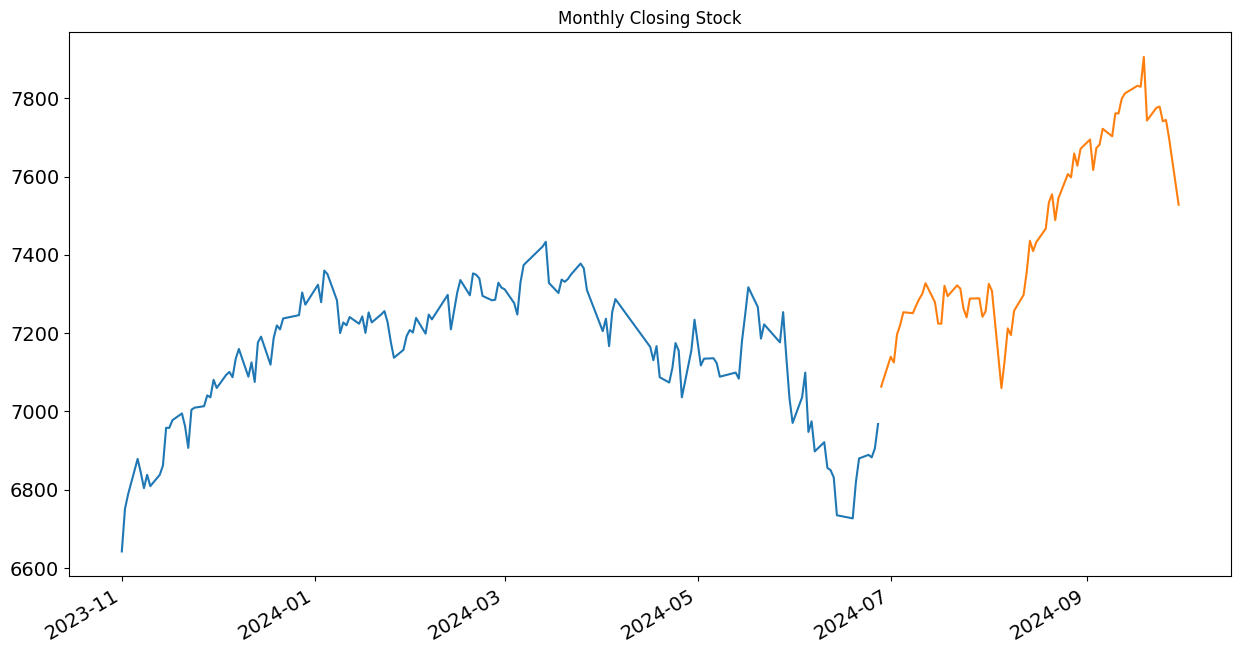

In [41]:
train["Close"].plot(figsize=(15,8), title= 'Monthly Closing Stock', fontsize=14)
test["Close"].plot(figsize=(15,8), title= 'Monthly Closing Stock', fontsize=14)

plt.show()

In [42]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [43]:
check_stationarity(train['Close'])

ADF Statistic: -2.977615
p-value: 0.037038
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577
Stationary


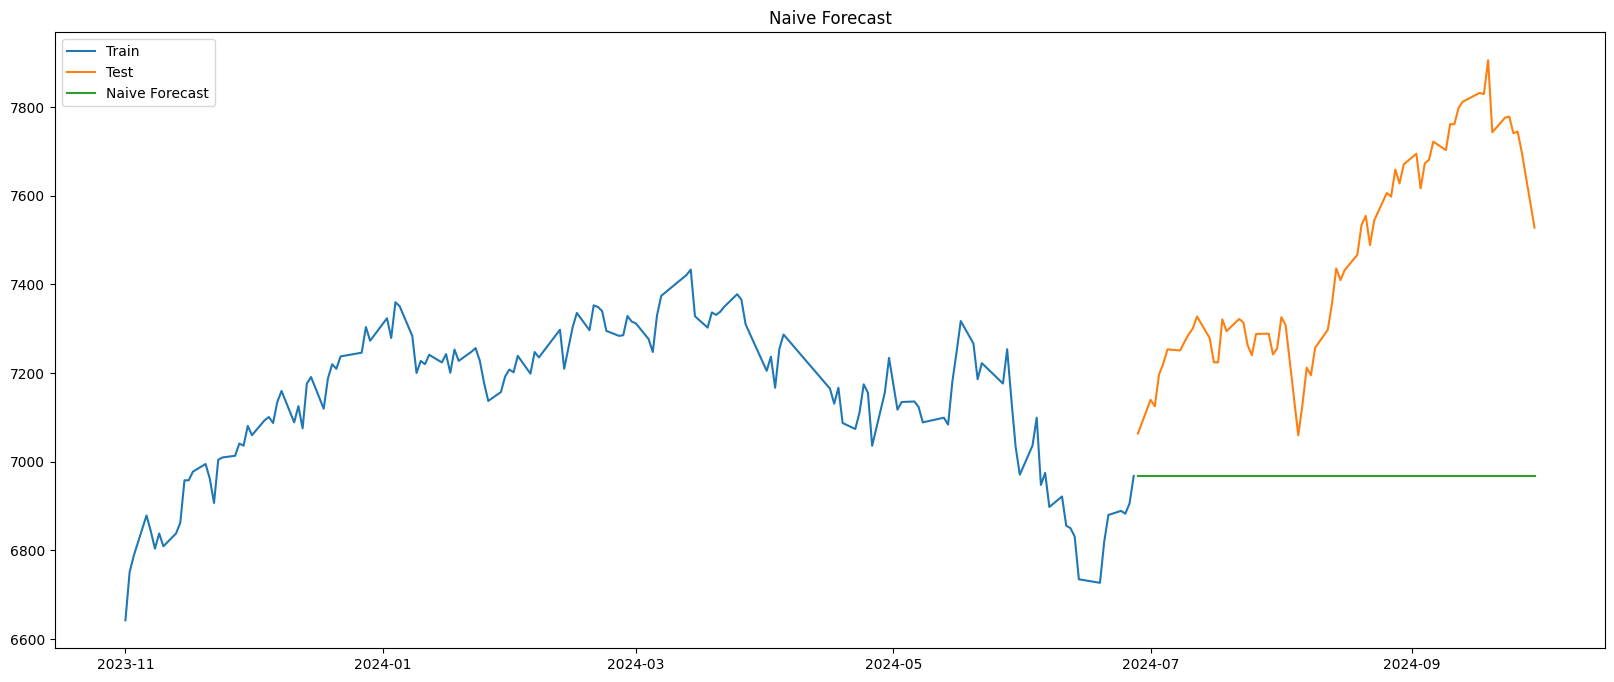

In [44]:
dd= np.asarray(train['Close'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(20,8))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index,test['Close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [46]:
rmse = sqrt(mean_squared_error(test["Close"], y_hat.naive))
mae = mean_absolute_error(test["Close"], y_hat.naive)

print("mae :",mae)
print("rmse :",rmse)

mae : 485.93441495028407
rmse : 538.4797449674608


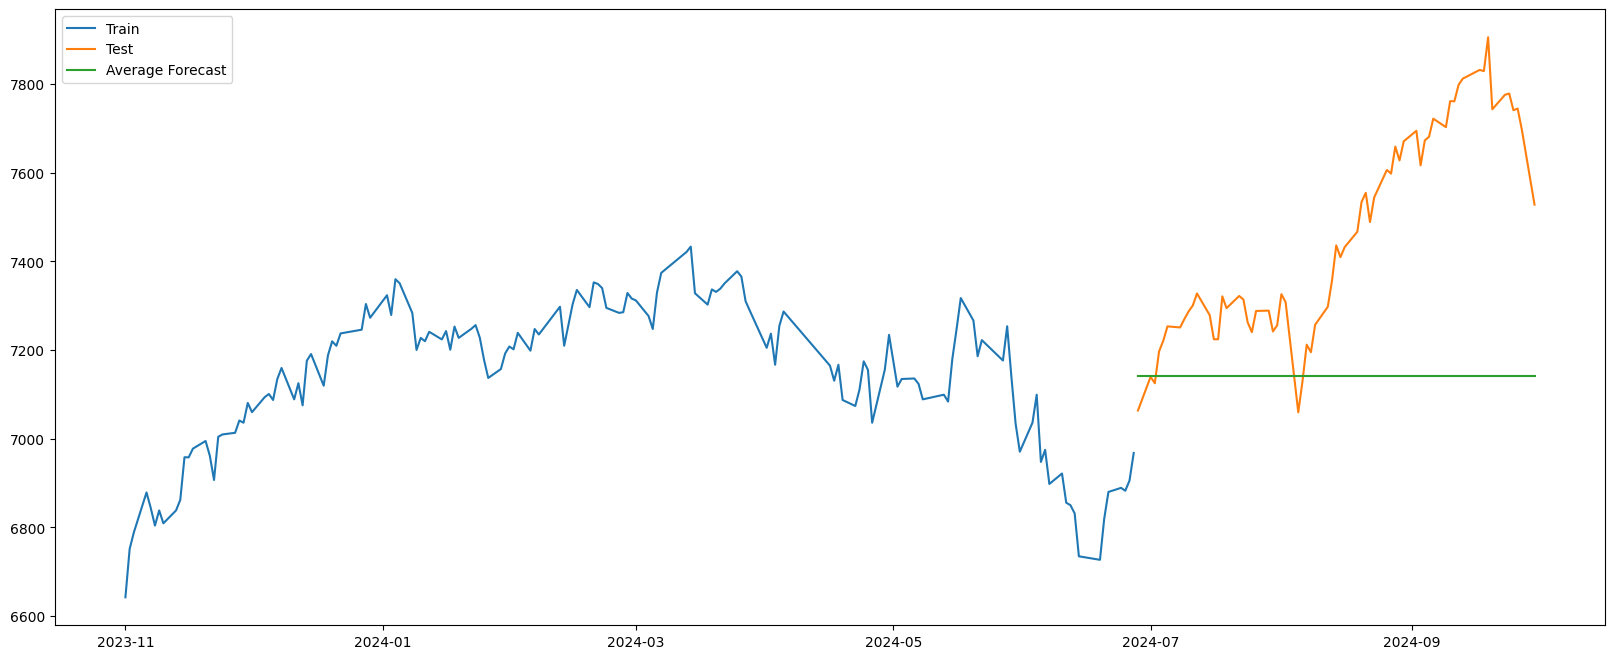

In [47]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Close'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [49]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["avg_forecast"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["avg_forecast"])))

mae : 318.36988093828876
rmse : 389.3244609041131


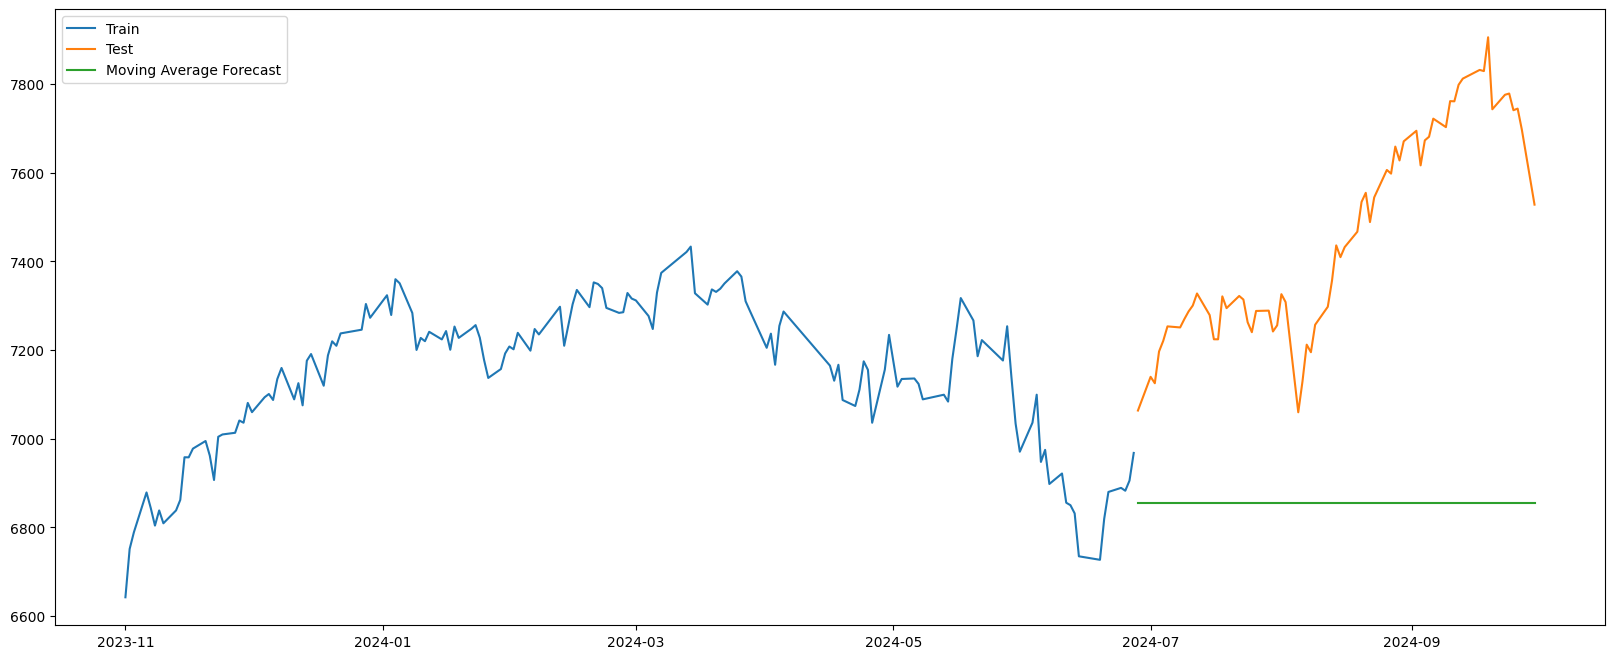

In [50]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Close'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(20,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [52]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["moving_avg_forecast"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["moving_avg_forecast"])))

mae : 598.434577710701
rmse : 641.834966254513


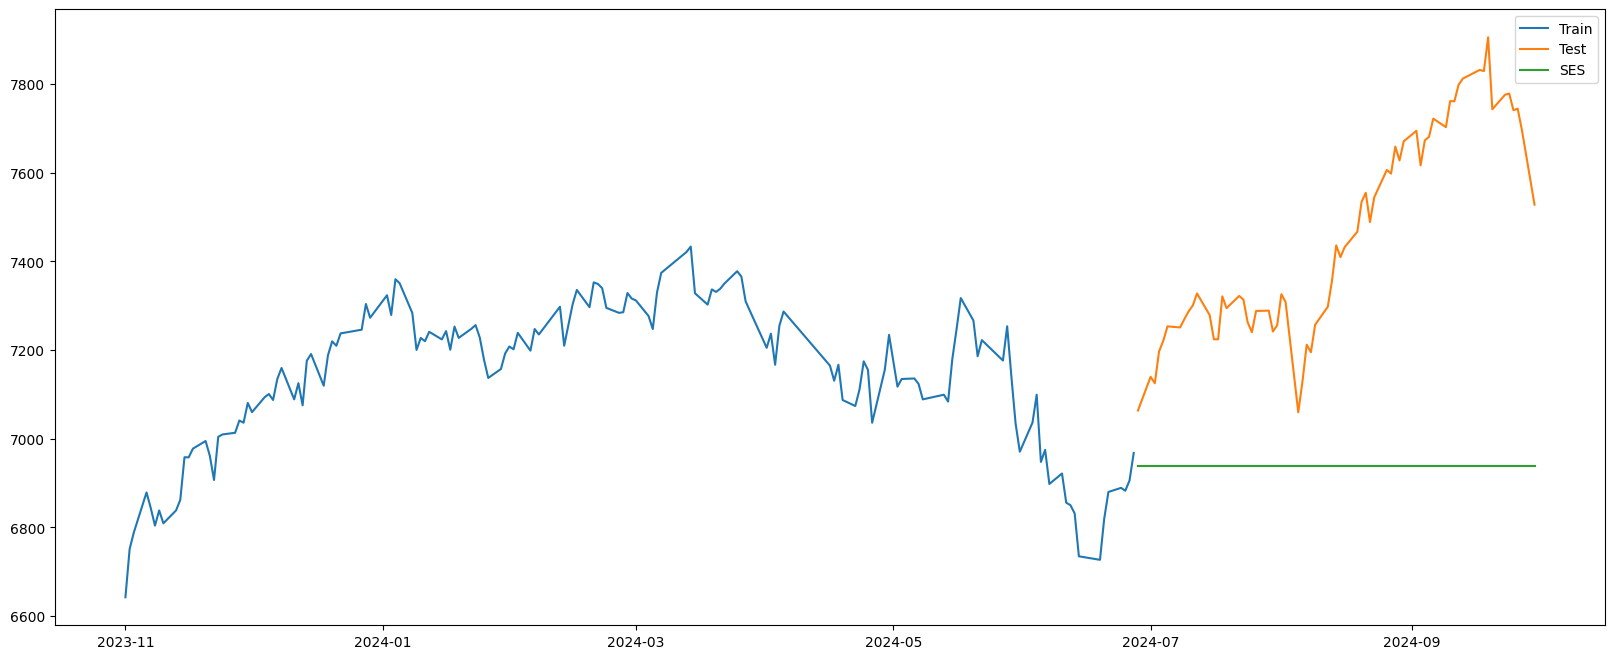

In [53]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [54]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["SES"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["SES"])))

mae : 515.264675073233
rmse : 565.0892544416953


/var/folders/qv/dgjs99p9327b4n569rm0j4000000gn/T/ipykernel_29896/2652560449.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
/opt/miniconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


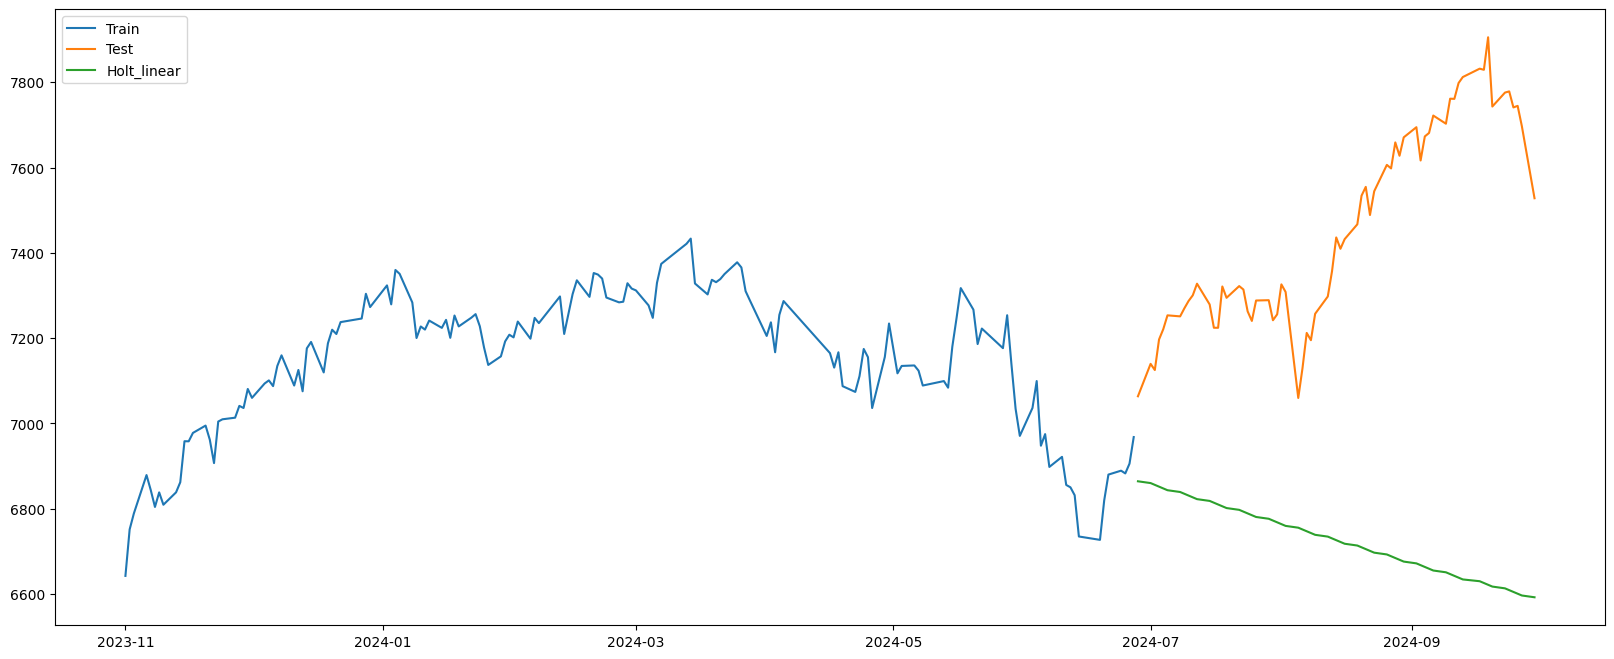

In [55]:
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [56]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["Holt_linear"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["Holt_linear"])))

mae : 725.6137849916577
rmse : 787.3738343775439


/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


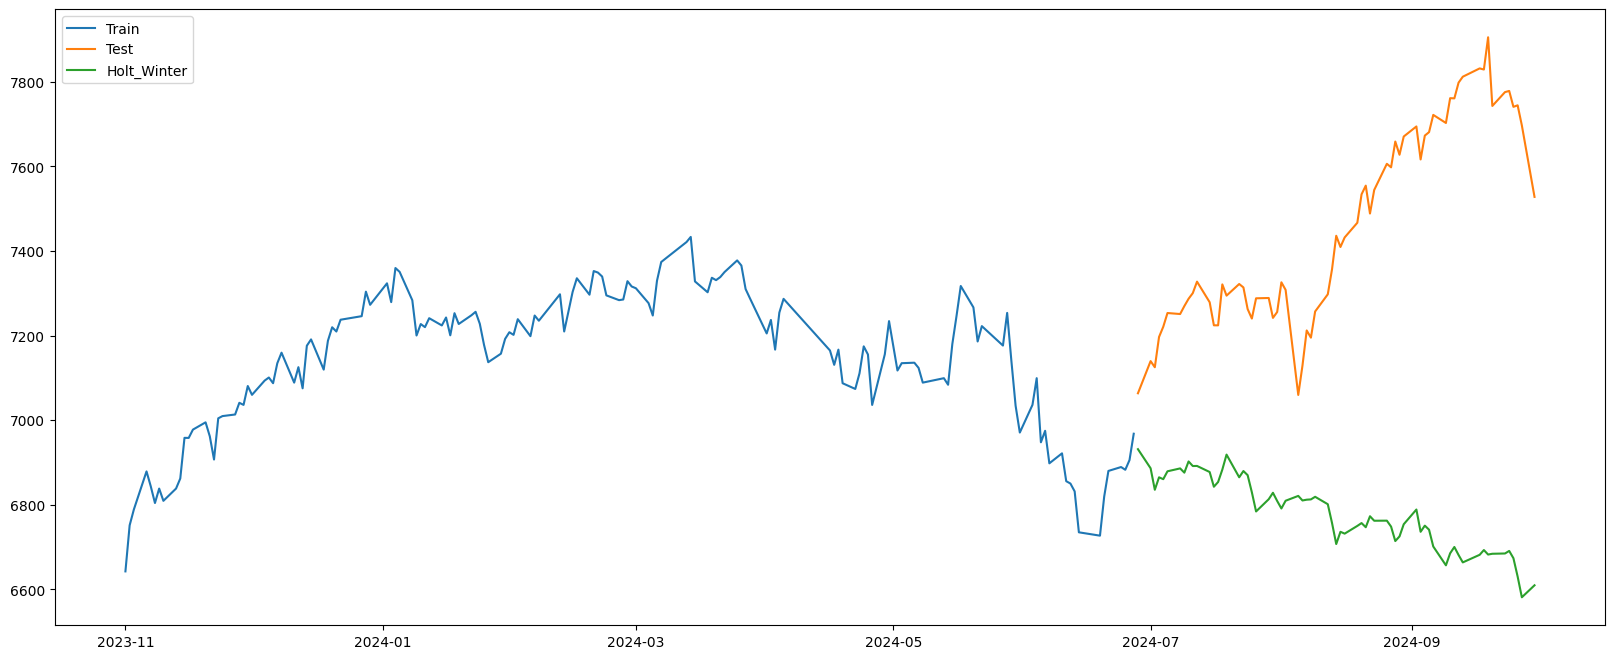

In [57]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=31 ,trend='multiplicative', seasonal='multiplicative',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [59]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["Holt_Winter"])))

mae : 675.467516902126
rmse : 740.8655072402389


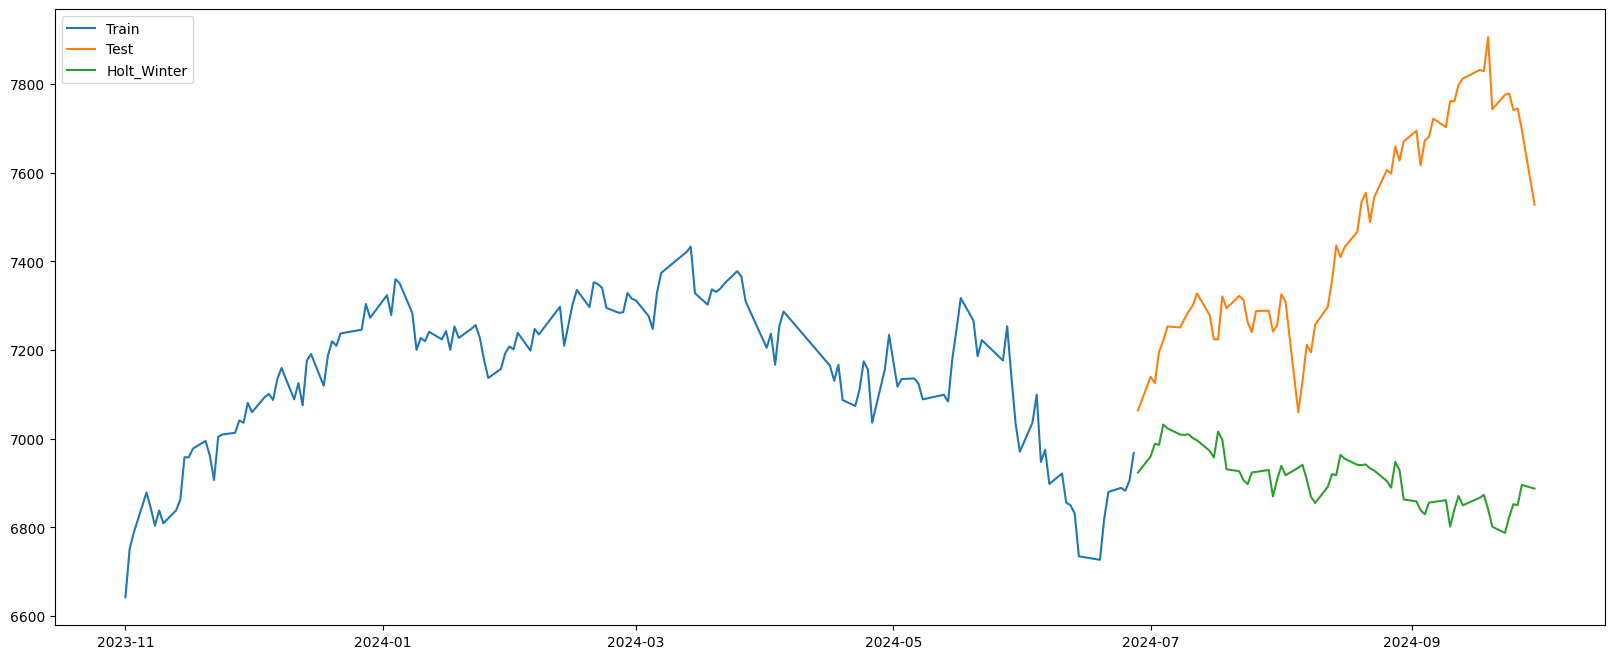

In [60]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=30 ,trend='multiplicative', seasonal='additive',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [61]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["Holt_Winter"])))

mae : 540.5398885208332
rmse : 607.0085440302344


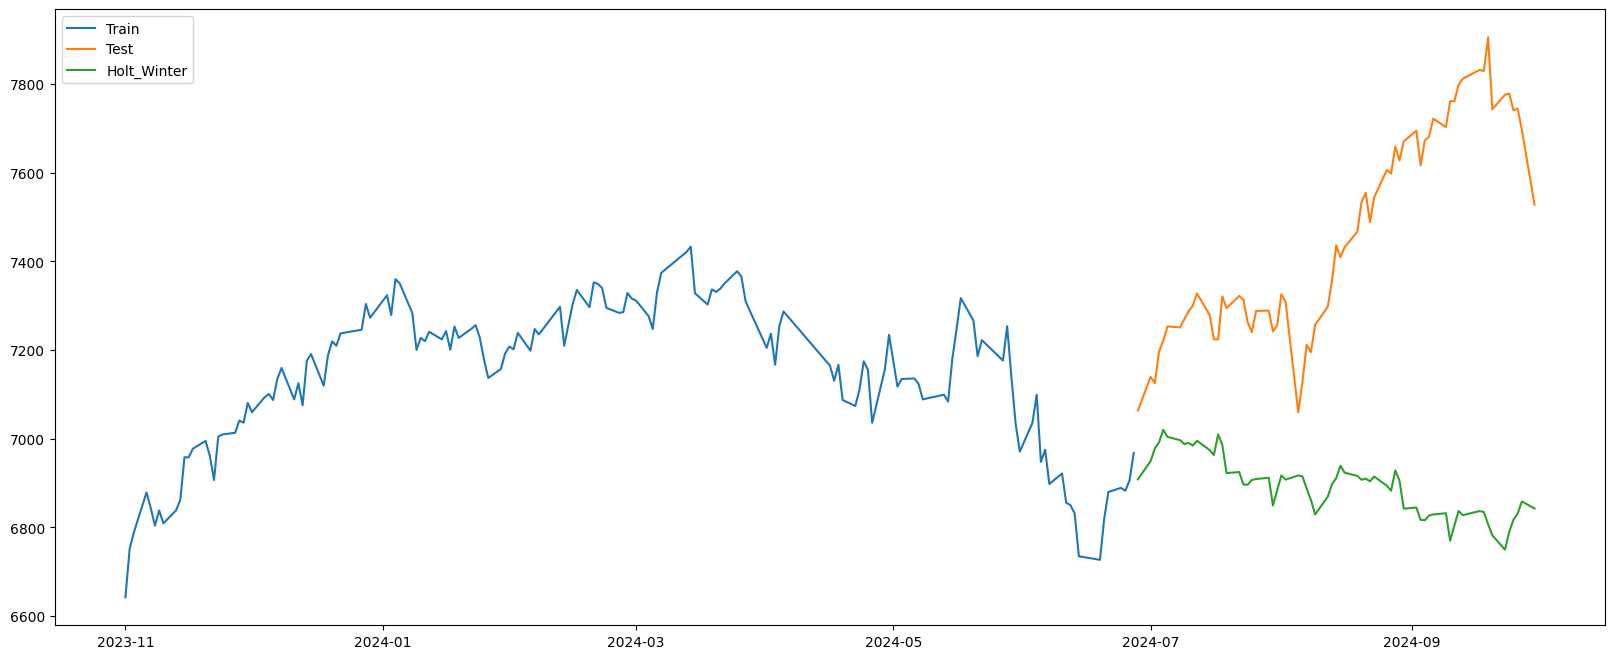

In [62]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=30 ,trend='additive', seasonal='multiplicative',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [63]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["Holt_Winter"])))

mae : 560.2661456820513
rmse : 627.6819354130092


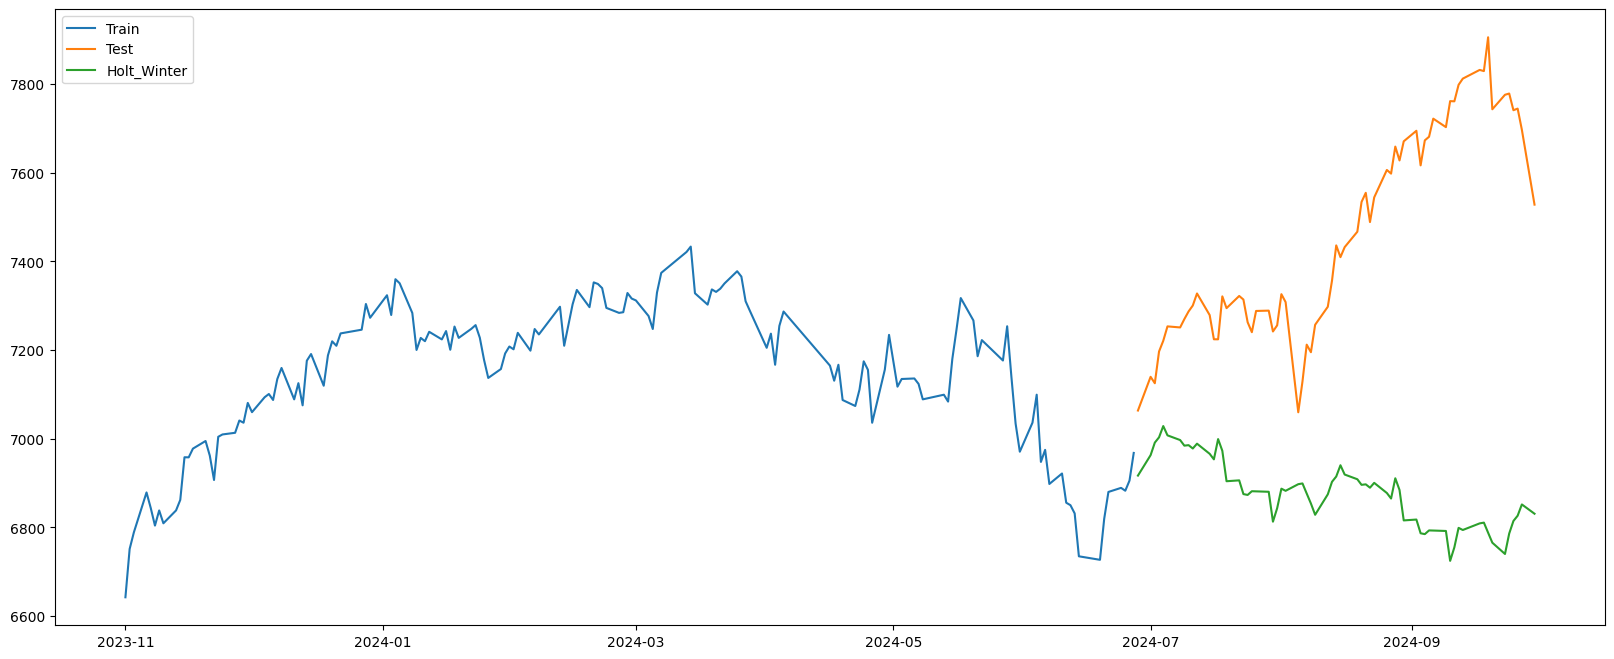

In [64]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=30 ,trend='additive', seasonal='additive',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [65]:
print("mae :", mean_absolute_error(test["Close"], y_hat_avg["Holt_Winter"]))
print("rmse :", sqrt(mean_squared_error(test["Close"], y_hat_avg["Holt_Winter"])))

mae : 575.4103688793218
rmse : 644.5945773919354
